### Import libraries and file

In [21]:
import pandas as pd
import csv
import matplotlib
import numpy as np
import warnings
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform, pdist
from scipy.cluster.hierarchy import complete, fcluster
from scipy.cluster.hierarchy import linkage
import seaborn as sns
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [22]:
#increase width to 100% in Jupyter Notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Make plots inline
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
#from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('pdf', 'svg')

In [23]:
%%javascript
IPython.notebook.kernel.execute(`notebookName = '${window.document.getElementById("notebook_name").innerHTML}'`);

<IPython.core.display.Javascript object>

In [24]:
notebookName

'waze_netflix_you_tube'

In [25]:
MIN_APPS = 1
MAX_APPS = 71
MAX_GRAPH_WIDTH = 40
MAX_GRAPH_HEIGHT = 150
GROUP_NAME = 'GRUPO APLICATIVO - '
GROUP_NAME_APP = ['MAPS', 'NETFLIX', 'WAZE / FACEBOOK', 'WESYNC (TENCENT - WECHAT) - GRUPO-A20', 'AFARIA(SAP)/IM - GRUPO-E32', 'ANTIVIRUS(NORTON / AVIRA / AVAST-ANTI-THEFT) - GRUPO-F44', 'YOU TUBE - GRUPO-H41', 'KITAPPS - GRUPO-H44']

### Trick to allow make huge numbers of recursion ( if needed)

In [26]:
import sys
sys.setrecursionlimit(100000)

### Files to load

In [27]:
apps_permission = '../apps_permission.csv'

In [28]:
aosp_permissions_list = '../AOSP_permissions_list.csv'

In [29]:
clustered_apps_per_line = '../../csv-files/Counted_apps_per_line.csv'

In [30]:
identical_objects = '../../csv-files/listsIdenticalObjsFormated.txt'

### Function do find the max size of columns

In [31]:
#preprocessing
def get_max_len():
    with open(apps_permission, 'r') as csvfile:
        reader = csv.reader(csvfile)
        num = []
        for i, row in enumerate(reader):
            num.append(len(row))
        m = max(num)
        #print (m)
        return m
    
print(get_max_len())

126


In [32]:
#preprocessing
def get_aosp_permissions():
    with open(aosp_permissions_list, 'r') as csvfile:
        reader = csv.reader(csvfile)
        aosp_permissions = set()
        for i, row in enumerate(reader):
            aosp_permissions.add(row[0].lower())
        return aosp_permissions

In [33]:
def read_lines_from_csv(list_of_lines, filename):
    list_lines = []
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile)
        for i, row in enumerate(reader):
            if i+1 in list_of_lines:
                #Converts list of strings into list of ints --> results = list(map(int, results))
                list_lines.append(list(map(int, row)))
        return list_lines

### Read and show dataset

In [34]:
df = pd.read_csv(apps_permission, header=None, na_values=0, names=range(get_max_len()), low_memory=False)

In [35]:
df_statistics = pd.read_csv(clustered_apps_per_line, header=None, names=['line','QtyApps'])

In [36]:
select_df_statistics_by_qty_apps = df_statistics[(df_statistics['QtyApps']>=MIN_APPS) & (df_statistics['QtyApps']<=MAX_APPS)].sort_values(by=['line'])

In [37]:
# list_of_lines_by_qty_apps = list(select_df_statistics_by_qty_apps['line'])
list_of_lines_by_qty_apps = [733,826,901,1027,1237,1041,2159,2360]

In [38]:
list_of_lines_by_qty_apps

[733, 826, 901, 1027, 1237, 1041, 2159, 2360]

In [39]:
list_of_all_worthy_identical_objects = read_lines_from_csv(list_of_lines_by_qty_apps, identical_objects)
#list_of_all_worthy_identical_objects

In [40]:
graph_qty = len(list_of_all_worthy_identical_objects)

In [41]:
graph_qty

8

### Filter Dataset

In [42]:
permissions = set()
permissions_list = set()
apps_list = set()
# official_permissions = get_oficial_permissions()
#mix_permissions = get_mix_permissions()
aosp_permissions = get_aosp_permissions()


for index, row in df.iterrows():
    app = row[0]
    
    for perm in row[1:]:
        if str(perm) == 'nan':
            break
        else:
            perm_list = perm.split('.')
            if 'permission' in perm_list:
                if perm_list[-1].lower() in aosp_permissions:
                    perm_t = perm_list[-1].lower()
                
                if 'token' not in perm_t and len(perm_t) > 0:
                    permissions.add(perm_t)
                    permissions_list.add((app, perm_t))
                    apps_list.add(app)

In [43]:
len(apps_list)

95458

In [44]:
len(aosp_permissions)

456

In [45]:
len(permissions)

200

### Create new dataframe from filter permissions and apps

In [46]:
df_apps = pd.DataFrame(list(permissions_list))
df_apps.head()

,0,1
0,com.a12164352065263daee5d9d89a.a72396188a,vibrate
1,com.space.reload.wargate,wake_lock
2,ch.netcetera.polizeischaffhausen,wake_lock
3,de.cytrus.quick_mix.hausdesigner,write_external_storage
4,com.ilovelibrary.v3.patch1_ptt,access_network_state


### Create a matrix from dataframe

In [47]:
matrix = pd.crosstab(index=df_apps[0], columns = df_apps[1])
#matrix.to_csv('permissions_matrix.csv', index=False)

In [48]:
matrix.shape

(95458, 200)

In [49]:
map_perm = {idx: c for idx, c in enumerate(matrix.columns)}

In [50]:
array_matrix = np.array(matrix)

In [51]:
array_matrix.shape

(95458, 200)

In [52]:
perm_df = pd.DataFrame(map_perm, index = [0])

In [53]:
perm_df = perm_df.T

In [54]:
#np.save('matrix_local_aosp_permission.npy', matrix)

In [55]:
#matrix = np.load('matrix_local_aosp_permission.npy')

### Starts the dynamic part of the algorithm the works like a huge function

In [56]:
def generate_sliced_matrix(list_of_clusters):
    sliced_matrix = []
    for i, cluster_i in enumerate(list_of_clusters):
        row_idx = np.array(cluster_i)
        matrix_sliced = array_matrix[row_idx, :]
        sliced_matrix.append(matrix_sliced)
    return sliced_matrix

In [57]:
def generate_heatmaps_from_worthy_clusters(list_of_clusters):
    heatmaps = []
    for i, cluster_i in enumerate(list_of_clusters):
        row_idx = np.array(cluster_i)
        matrix_sliced = array_matrix[row_idx, :]
        heatmap_test = sns.heatmap(matrix_sliced[:,:], xticklabels = True, yticklabels = True, cmap="YlGnBu", linewidths=.5)
        #heatmaps.append(heatmap_test)
    #return heatmaps

### Variables needed to plot graphs

In [58]:
#Set variable to plot graphics
#list_of_all_worthy_identical_objects_sorted = sorted(list_of_all_worthy_identical_objects, key=len, reverse=True)
list_of_all_worthy_identical_objects_sorted = sorted(list_of_all_worthy_identical_objects, key=len)
sliced_matrix = generate_sliced_matrix(list_of_all_worthy_identical_objects_sorted)
danger_permissions_idx = [2,4,8,11,14,38,47,49,56,57,58,76,98,118,127,147,177,183,184,190]
danger_permissions_idx_weight = [50,60,10,10,60,10,60,80,50,50,50,70,50,20,30,50,10,20,100,40]
#Defines how many times a permission must be considered in the graph
threshold_percentage = 0.4

### Analysis each group graph and made an energy weight heatmap

In [59]:
for i in range(graph_qty):
    ar_mean = np.mean(sliced_matrix[i][:,danger_permissions_idx],0)
    ar_filtered = np.where(ar_mean<threshold_percentage, 0, 1)
    result = ar_filtered*danger_permissions_idx_weight
    if i == 0:
        group_array = result
    else:
        group_array = np.vstack([group_array, result])
sum_rows = np.sum(group_array, axis=1)
xpto = sum_rows.reshape(np.size(sum_rows),1)

#set x axis to Energy analysis graph
x_axis = [map_perm[idx] for idx in danger_permissions_idx]

#set x axis to Permission graph
xticks = [map_perm[idx] for idx in map_perm]

### Energys Analysis Graph

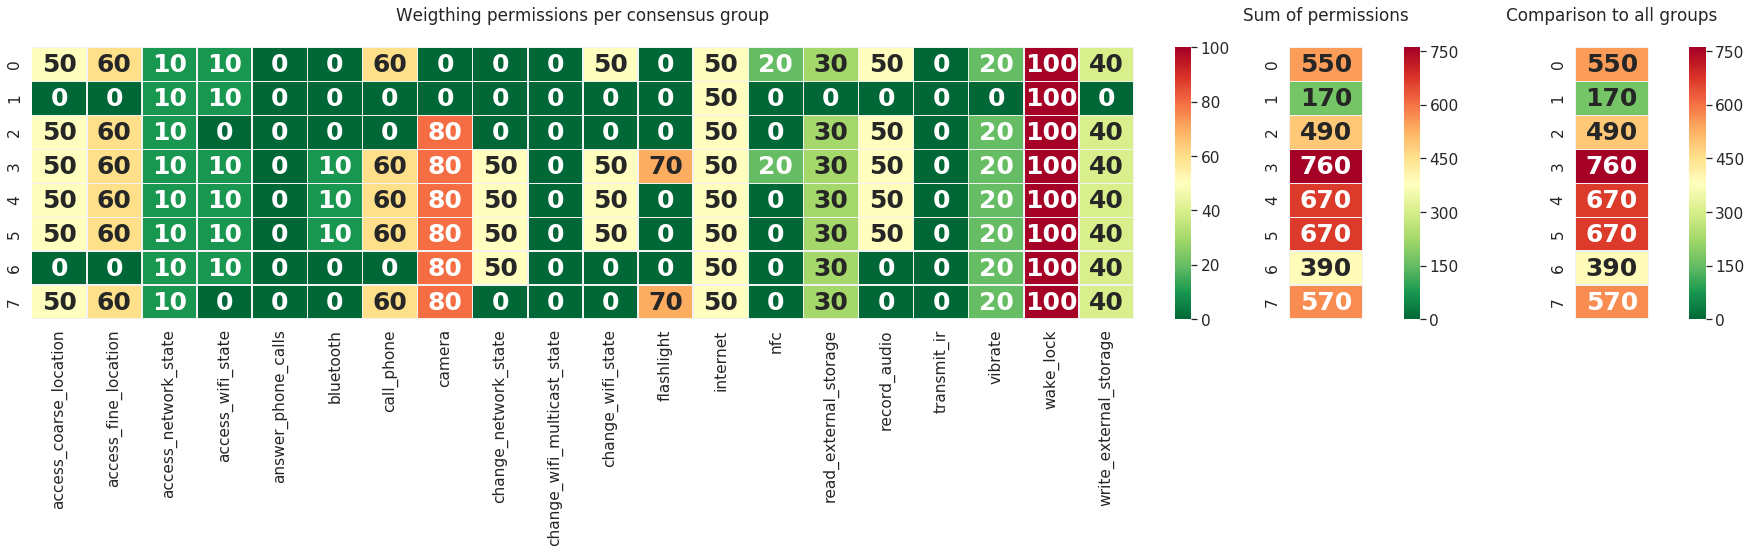

In [60]:
fig = plt.figure(figsize=(30,5))
sns.set(font_scale=1.4)
#grid size
gs = gridspec.GridSpec(1, 30, wspace=2.5, hspace=.8)
#define axis
ax1 = plt.subplot(gs[0, :-10])
ax_bar1 = plt.subplot(gs[0, -10:-9])
ax2 = plt.subplot(gs[0,-8:-6])
ax_bar2 = plt.subplot(gs[0, -6:-5])
ax3 = plt.subplot(gs[0,-3:-1])
ax_bar3 = plt.subplot(gs[0, -1])
#set axis' title
ax1.set_title("Weigthing permissions per consensus group\n")
ax2.set_title("Sum of permissions\n")
ax3.set_title("Comparison to all groups\n")
#drawing graphs
im1 = sns.heatmap(group_array, xticklabels = x_axis, annot=True, annot_kws={"weight": 'bold', "size":25}, fmt="d", cmap="RdYlGn_r", linewidths=.5, linecolor="#F2F2F2", ax=ax1, cbar_ax=ax_bar1)
im2 = sns.heatmap(xpto, annot=True, annot_kws={"weight": 'bold', "size":25}, xticklabels=False, fmt="d", cmap="RdYlGn_r", linewidths=.5, linecolor="#F2F2F2", ax=ax2,vmin=0,  cbar_ax=ax_bar2)
im3 = sns.heatmap(xpto, annot=True, annot_kws={"weight": 'bold', "size":25}, xticklabels=False, fmt="d", cmap="RdYlGn_r", linewidths=.5, linecolor="#F2F2F2", ax=ax3, vmin=0, vmax=760, cbar_ax=ax_bar3)
#plt.show()
#Save figure on jupyter-notebook
fig_name_png = "pictures/" + notebookName + "_energy_analysis.png"
plt.savefig(fig_name_png, transparent=False)
fig_name_pdf = "pictures/" + notebookName + "_energy_analysis.pdf"
plt.savefig(fig_name_pdf, papertype='a4')

In [61]:
GROUP_NAME_APP = ['MAPS', 'NETFLIX', 'WAZE / FACEBOOK', 'WESYNC (TENCENT - WECHAT) - GRUPO-A20', 'AFARIA(SAP)/IM - GRUPO-E32', 'ANTIVIRUS(NORTON / AVIRA / AVAST-ANTI-THEFT) - GRUPO-F44', 'YOU TUBE - GRUPO-H41', 'KITAPPS - GRUPO-H44']
GROUP_NAME_APP

['MAPS',
 'NETFLIX',
 'WAZE / FACEBOOK',
 'WESYNC (TENCENT - WECHAT) - GRUPO-A20',
 'AFARIA(SAP)/IM - GRUPO-E32',
 'ANTIVIRUS(NORTON / AVIRA / AVAST-ANTI-THEFT) - GRUPO-F44',
 'YOU TUBE - GRUPO-H41',
 'KITAPPS - GRUPO-H44']

### Some random analysis

In [62]:
index_number = []
app_name = "com.kitapps"
package_name = matrix[matrix.index.str.contains(app_name)].index.values
for i in range(len(package_name)):
    index_number.append(matrix.index.get_loc(package_name[i]))
m2 = matrix.iloc[index_number, :]
m2[m2.columns[(m2 == 1).any()]]

1,access_coarse_location,access_fine_location,access_network_state,authenticate_accounts,call_phone,camera,flashlight,get_accounts,get_tasks,internet,read_external_storage,read_phone_state,use_credentials,vibrate,wake_lock,write_external_storage
0,,,,,,,,,,,,,,,,
com.kitapps.android.builder.abadrspring2014,1,1,1,0,1,1,0,0,0,1,1,1,0,1,1,1
com.kitapps.android.builder.acispring2014convention,1,1,1,0,1,1,1,0,0,1,1,1,0,1,1,1
com.kitapps.android.builder.acmnationalstudentconference,1,1,1,0,1,1,1,0,0,1,1,1,0,1,1,1
com.kitapps.android.builder.affiliate_summit_east_2014,1,1,1,0,1,1,1,0,0,1,1,1,0,1,1,1
com.kitapps.android.builder.aia_risk_compliance_and_audit_conference_2014,1,1,1,0,1,1,1,0,0,1,1,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
com.kitapps.android.builder.thirdworldcongressonadultguardianship,1,1,1,0,1,1,1,0,0,1,1,1,0,1,1,1
com.kitapps.android.builder.thpacificscienceintercongress,1,1,1,0,1,0,0,1,0,1,1,0,0,1,1,1
com.kitapps.android.builder.vacation.com16thinternationalconferencetradeshow2014,1,1,1,0,1,1,1,0,0,1,1,1,0,1,1,1


In [63]:
# app_name = "com.kitapps"
# matrix[matrix.index.str.contains(app_name)].index.values

In [64]:
index_number = []
app_name = 'com.google.android.youtube'
package_name = matrix[matrix.index.str.match(app_name)].index.values[0]
index_number.append(matrix.index.get_loc(package_name))
index_number

[33002]

In [65]:
index_number = []
app_name = 'com.google.android.apps.maps'
package_name = matrix[matrix.index.str.match(app_name)].index.values[0]
index_number.append(matrix.index.get_loc(package_name))
index_number

[32987]

In [66]:
index_number = []
app_name = 'com.waze'
package_name = matrix[matrix.index.str.match(app_name)].index.values[0]
index_number.append(matrix.index.get_loc(package_name))
index_number

[67913]

In [67]:
index_number = []
app_name = 'com.netflix'
package_name = matrix[matrix.index.str.match(app_name)].index.values[0]
index_number.append(matrix.index.get_loc(package_name))
index_number

[48246]

In [68]:
# #1041
# group44 = [8563,9255,13281,40479,40480,40481,40482,40483,40484,40485,40487,40488,40489,40491,40492,40493,40494,40495,40496,40497,40499,40500,40501,40502,40503,40509,40510,40511,40513,40514,40515,40516,40517,40518,40520,40521,40522,40524,40525,40526,40527,40529,40531,40532,40533,40536,40537,40538,40539,40541,40542,40543,40545,40546,40547,40549,40550,40551,50161,50162,50164,50165,50166,50167,50168,50169,50170,50171,50172,68580]
# m2 = matrix.iloc[group44, :]
# m2[m2.columns[(m2 == 1).any()]]
# # len(group44)

In [69]:
m2 = matrix.iloc[list_of_all_worthy_identical_objects_sorted[0], :]
m2[m2.columns[(m2 == 1).any()]]

1,access_coarse_location,access_fine_location,access_network_state,access_wifi_state,call_phone,change_wifi_state,disable_keyguard,get_accounts,internet,manage_accounts,...,read_external_storage,read_phone_state,receive_boot_completed,record_audio,use_credentials,vibrate,wake_lock,write_call_log,write_contacts,write_external_storage
0,,,,,,,,,,,,,,,,,,,,,
com.google.android.apps.maps,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [70]:
m2 = matrix.iloc[list_of_all_worthy_identical_objects_sorted[1], :]
m2[m2.columns[(m2 == 1).any()]]

1,access_network_state,access_wifi_state,bluetooth,change_wifi_multicast_state,disable_keyguard,get_accounts,get_tasks,internet,modify_audio_settings,read_phone_state,read_profile,record_audio,system_alert_window,wake_lock
0,,,,,,,,,,,,,,
com.experian.freecreditscore,1,1,0,0,0,1,1,1,0,1,1,0,0,1
com.getpaste.barcelona,1,1,0,0,1,1,1,1,0,1,0,0,1,1
com.getpaste.correosdelecuador,1,1,0,0,1,1,1,1,0,1,0,0,1,1
com.getpaste.teleamazonas,1,1,0,0,1,1,1,1,0,1,0,0,1,1
com.getpaste.zenhabits,1,1,0,0,1,1,1,1,0,1,0,0,1,1
com.netflix.mediaclient,1,1,1,1,0,1,1,1,1,1,0,1,0,1
com.playkot.farklelive,1,1,0,0,0,1,1,1,1,1,0,0,0,1
jp.co.transcosmos.bunnyhunt,1,1,0,0,1,1,1,1,0,1,0,0,1,1


In [71]:
m2 = matrix.iloc[list_of_all_worthy_identical_objects_sorted[2], :]
m2[m2.columns[(m2 == 1).any()]]

1,access_coarse_location,access_fine_location,access_location_extra_commands,access_network_state,access_wifi_state,authenticate_accounts,bluetooth,broadcast_sticky,call_phone,camera,...,use_credentials,vibrate,wake_lock,write_calendar,write_call_log,write_contacts,write_external_storage,write_secure_settings,write_settings,write_sync_settings
0,,,,,,,,,,,,,,,,,,,,,
com.Hanbiro.groupware.kgg,1,1,0,1,0,1,0,0,1,1,...,1,1,1,1,0,1,1,0,0,1
com.facebook.katana,1,1,0,1,1,1,0,1,0,1,...,0,1,1,1,1,1,1,0,0,1
com.waze,1,1,1,1,0,1,1,1,0,1,...,1,1,1,0,0,1,1,1,1,1
uk.co.myfirmsapp.coward,1,1,1,1,0,1,0,0,0,1,...,0,1,1,1,0,1,1,0,1,1
uk.co.myfirmsapp.dfc,1,1,1,1,0,1,0,0,0,1,...,0,1,1,1,0,1,1,0,1,1
uk.co.myfirmsapp.dng,1,1,1,1,0,1,0,0,0,1,...,0,1,1,1,0,1,1,0,1,1
uk.co.myfirmsapp.grant,1,1,1,1,0,1,0,0,0,1,...,0,1,1,1,0,1,1,0,1,1
uk.co.myfirmsapp.km,1,1,1,1,0,1,0,0,0,1,...,0,1,1,1,0,1,1,0,1,1
uk.co.myfirmsapp.pnl,1,1,1,1,0,1,0,0,0,1,...,0,1,1,1,0,1,1,0,1,1


In [72]:
m2 = matrix.iloc[list_of_all_worthy_identical_objects_sorted[3], :]
m2[m2.columns[(m2 == 1).any()]]

1,access_coarse_location,access_fine_location,access_location_extra_commands,access_mock_location,access_network_state,access_wifi_state,authenticate_accounts,bind_accessibility_service,bind_wallpaper,bluetooth,...,vibrate,wake_lock,write_calendar,write_call_log,write_contacts,write_external_storage,write_secure_settings,write_settings,write_sms,write_sync_settings
0,,,,,,,,,,,,,,,,,,,,,
ch.gridvision.ppam.androidautomagic,1,1,1,0,1,1,0,0,0,1,...,1,1,1,1,1,1,1,1,1,1
com.bulletproof.voicerec,1,1,0,0,1,1,1,0,0,1,...,1,1,1,1,1,1,0,1,1,1
com.bulletproof.voicerec.avx,1,1,0,0,1,1,1,0,0,1,...,1,1,1,1,1,1,0,1,1,1
com.bulletproof.voicerec.avxfree,1,1,0,0,1,1,1,0,0,1,...,1,1,1,1,1,1,0,1,1,1
com.bulletproof.voicerec.evan,1,1,0,0,1,1,1,0,0,1,...,1,1,1,1,1,1,0,1,1,1
com.bulletproof.voicerec.evanintern,1,1,0,0,1,1,1,0,0,1,...,1,1,1,1,1,1,0,1,1,1
com.bulletproof.voicerec.intern,1,1,0,0,1,1,1,0,0,1,...,1,1,1,1,1,1,0,1,1,1
com.comodo.pimsecure,1,1,0,1,1,1,0,0,0,0,...,1,1,1,1,1,1,0,1,1,0
com.jiubang.goscreenlock,1,1,0,1,1,1,0,1,0,1,...,1,1,1,1,1,1,0,1,1,0


In [73]:
m2 = matrix.iloc[list_of_all_worthy_identical_objects_sorted[4], :]
m2[m2.columns[(m2 == 1).any()]]

1,access_cache_filesystem,access_checkin_properties,access_coarse_location,access_fine_location,access_keyguard_secure_storage,access_location_extra_commands,access_mock_location,access_network_state,access_notification_policy,access_surface_flinger,...,vibrate,wake_lock,write_apn_settings,write_call_log,write_contacts,write_external_storage,write_secure_settings,write_settings,write_sms,write_sync_settings
0,,,,,,,,,,,,,,,,,,,,,
com.Android.Afaria,0,0,1,1,0,0,0,1,0,0,...,1,1,0,1,1,1,0,1,1,1
com.afaria.client.samsung2client,0,0,1,1,0,0,0,1,0,0,...,1,1,0,1,1,1,1,1,1,1
com.aibel.android.im,0,1,1,1,0,1,1,1,0,1,...,1,1,1,1,1,1,1,1,1,1
com.boryazilim.android.bormdm.app,0,0,1,1,0,0,0,1,0,0,...,1,1,0,1,0,1,1,1,0,0
com.clovis.android.im,0,1,1,1,0,1,1,1,0,1,...,1,1,1,1,1,1,1,1,1,1
com.clovis4polycom.android.im,0,1,1,1,0,1,1,1,0,1,...,1,1,1,1,1,1,1,1,1,1
com.clovis4radvision.android.im,0,1,1,1,0,1,1,1,0,1,...,1,1,1,1,1,1,1,1,1,1
com.cmr.android.im,0,1,1,1,0,1,1,1,0,1,...,1,1,1,1,1,1,1,1,1,1
com.didirelease.view,0,0,1,1,0,0,0,1,0,0,...,1,1,0,0,1,1,0,1,0,0


In [74]:
m2 = matrix.iloc[list_of_all_worthy_identical_objects_sorted[5], :]
m2[m2.columns[(m2 == 1).any()]]

1,access_coarse_location,access_fine_location,access_location_extra_commands,access_mock_location,access_network_state,access_notification_policy,access_wifi_state,authenticate_accounts,battery_stats,bind_accessibility_service,...,write_contacts,write_external_storage,write_gservices,write_media_storage,write_secure_settings,write_settings,write_sms,write_social_stream,write_sync_settings,write_user_dictionary
0,,,,,,,,,,,,,,,,,,,,,
com.androidlost,1,1,0,0,1,0,1,0,0,0,...,0,1,0,0,1,1,1,0,0,0
com.antivirus,1,1,0,0,1,1,1,1,1,0,...,1,1,0,0,1,1,1,0,1,0
com.antivirus.tablet,1,1,0,0,1,1,1,1,1,0,...,1,1,0,0,1,1,1,0,1,0
com.avast.android.at_play,1,1,0,0,1,0,1,0,0,0,...,1,1,0,0,1,1,1,0,0,1
com.avira.android,1,1,0,0,1,0,1,0,0,0,...,1,1,0,0,0,0,1,0,0,0
com.clomo.android.mdm,1,1,0,0,1,0,1,0,0,0,...,1,1,0,0,0,1,1,0,1,0
com.cyman.android,1,1,0,0,1,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0
com.cymansystem.android,1,1,0,0,1,0,1,0,0,0,...,0,1,0,0,0,1,1,0,0,0
com.fsecure.ms.kpn.consumer,1,1,0,0,1,0,1,0,0,0,...,1,1,0,0,0,1,1,0,1,0


In [75]:
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 30)
m2 = matrix.iloc[list_of_all_worthy_identical_objects_sorted[6], :]
m2[m2.columns[(m2 == 1).any()]]

1,access_network_state,access_wifi_state,authenticate_accounts,broadcast_sticky,camera,change_network_state,change_wifi_multicast_state,change_wifi_state,flashlight,foreground_service,get_accounts,get_tasks,internet,kill_background_processes,manage_accounts,manage_documents,nfc,read_external_storage,read_frame_buffer,receive_boot_completed,receive_sms,record_audio,restart_packages,system_alert_window,use_credentials,vibrate,wake_lock,write_external_storage,write_settings
0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
com.aapvs.international.jokes5.lite,1,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0
com.aapvs.international.lovestories5.lite,1,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0
com.aapvs.international.poems.lite,1,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0
com.coden.android.ebs,1,1,0,0,1,0,0,0,0,0,1,1,1,1,0,0,0,1,0,1,0,1,1,0,0,1,1,1,0
com.conjoinix.xscloudnotifier,1,1,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0,1,0,1,0,0,0,1,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
de.radpix,1,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,1,1,0
no.mellora.hseq.marineharvest,1,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,1,1,0
org.policefines.finesNotCommercial,1,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,1,1,1


In [393]:
pd.set_option('display.max_rows', 70)
pd.set_option('display.max_columns', 30)
m2 = matrix.iloc[list_of_all_worthy_identical_objects_sorted[7], :]
kitapps = m2[m2.columns[(m2 == 1).any()]]
kitapps.to_csv('kitapps.csv', encoding='utf-8')
kitapps

1,access_coarse_location,access_fine_location,access_mock_location,access_network_state,call_phone,camera,change_configuration,flashlight,get_tasks,internet,read_contacts,read_external_storage,read_phone_state,vibrate,wake_lock,write_external_storage
0,,,,,,,,,,,,,,,,
com.abi.android.builder.winterleadershipconference,1,1,0,1,1,1,0,0,0,1,0,1,1,1,1,1
com.agenda.ifcmall,1,1,0,1,1,1,1,0,0,1,0,1,1,1,1,1
com.appbuilder.u443161p697020,1,1,1,1,1,1,0,0,0,1,0,1,1,1,1,1
com.kitapps.android.builder.abadrspring2014,1,1,0,1,1,1,0,0,0,1,0,1,1,1,1,1
com.kitapps.android.builder.acispring2014convention,1,1,0,1,1,1,0,1,0,1,0,1,1,1,1,1
com.kitapps.android.builder.acmnationalstudentconference,1,1,0,1,1,1,0,1,0,1,0,1,1,1,1,1
com.kitapps.android.builder.affiliate_summit_east_2014,1,1,0,1,1,1,0,1,0,1,0,1,1,1,1,1
com.kitapps.android.builder.aia_risk_compliance_and_audit_conference_2014,1,1,0,1,1,1,0,1,0,1,0,1,1,1,1,1
com.kitapps.android.builder.aicannualforum2014,1,1,0,1,1,1,0,1,1,1,0,1,1,1,1,1


### Permission Analysis Graph

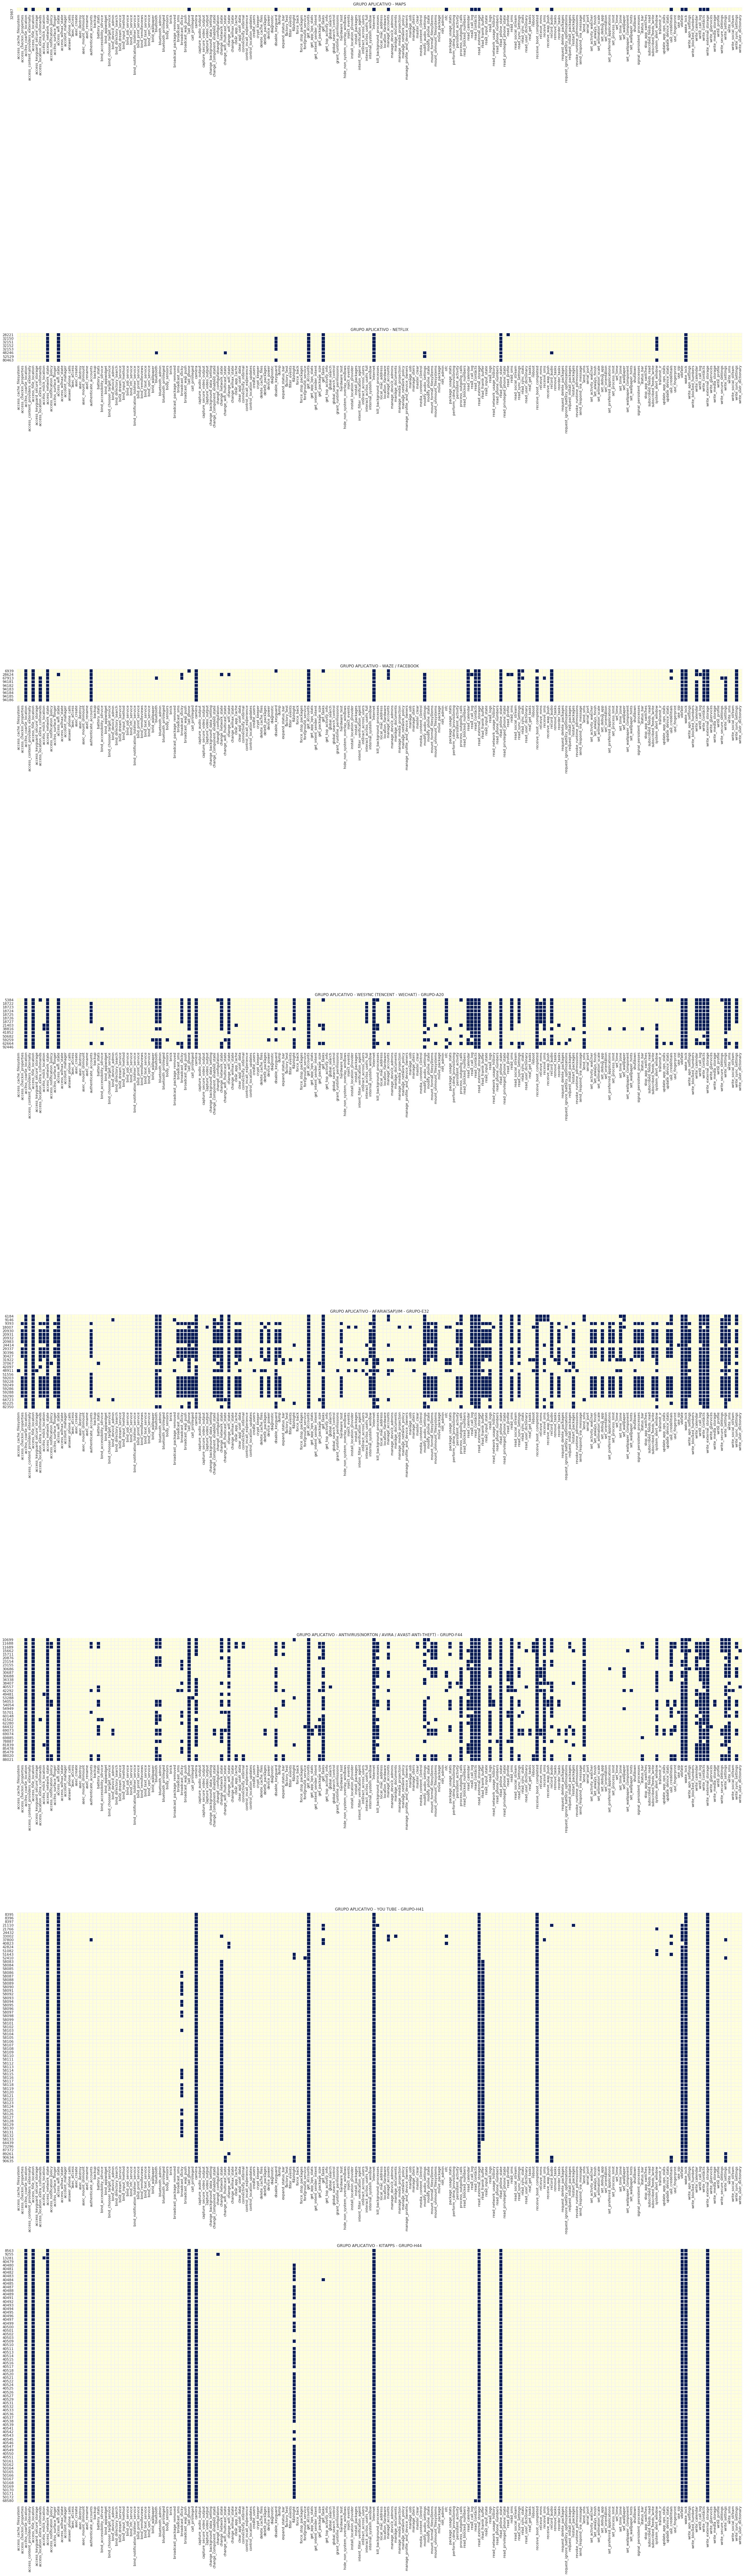

In [386]:
#fig, axs = plt.subplots(nrows=10, ncols=4)
sns.set(font_scale=1)
fig, axs = plt.subplots(graph_qty, 1, figsize=(MAX_GRAPH_WIDTH, MAX_GRAPH_HEIGHT))
# fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
for i in range(graph_qty):
#         axs[i].set_title(GROUP_NAME +str(i))
        axs[i].set_title(GROUP_NAME +GROUP_NAME_APP[i])
        sns.heatmap(sliced_matrix[i], xticklabels = xticks, cbar = False, square=True, yticklabels = list_of_all_worthy_identical_objects_sorted[i], cmap="YlGnBu", linewidths=.5, linecolor="#F2F2F2", ax=axs[i])
#Save figure on jupyter-notebook
fig_name_png = "pictures/" + notebookName + "_background.png"
plt.savefig(fig_name_png, transparent=False)
fig_name_pdf = "pictures/" + notebookName + "_background.pdf"
plt.savefig(fig_name_pdf, orientation='landscape', papertype='a4', format='pdf')